# setting EEG reference

In [1]:
import os
import mne

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file, verbose=False)
raw.crop(tmax=60).load_data()
raw.pick(['EEG 0{:02}'.format(n) for n in range(41, 60)])

Reading 0 ... 36037  =      0.000 ...    60.000 secs...
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


<Raw | sample_audvis_raw.fif, 19 x 36038 (60.0 s), ~8.1 MB, data loaded>

EEG measures a voltage (difference in electric potential) between each electrode and a reference electrode. This means that whatever signal is present at the reference electrode is effectively subtracted from all the measurement electrodes. Therefore, an ideal reference signal is one that captures none of the brain-specific fluctuations in electric potential, while capturing all of the environmental noise/interference that is being picked up by the measurement electrodes.

In practice, this means that the reference electrode is often placed in a location on the subject’s body and close to their head (so that any environmental interference affects the reference and measurement electrodes similarly) but as far away from the neural sources as possible (so that the reference signal doesn’t pick up brain-based fluctuations). Typical reference locations are the subject’s earlobe, nose, mastoid process, or collarbone. Each of these has advantages and disadvantages regarding how much brain signal it picks up (e.g., the mastoids pick up a fair amount compared to the others), and regarding the environmental noise it picks up (e.g., earlobe electrodes may shift easily, and have signals more similar to electrodes on the same side of the head).

Even in cases where no electrode is specifically designated as the reference, EEG recording hardware will still treat one of the scalp electrodes as the reference, and the recording software may or may not display it to you (it might appear as a completely flat channel, or the software might subtract out the average of all signals before displaying, making it look like there is no reference).

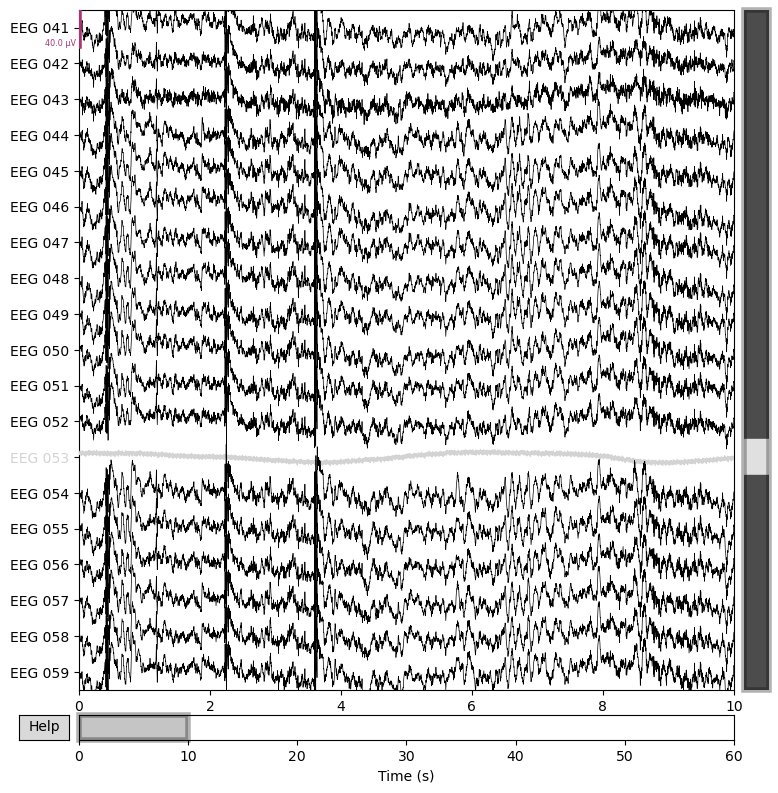

In [3]:
raw.plot();

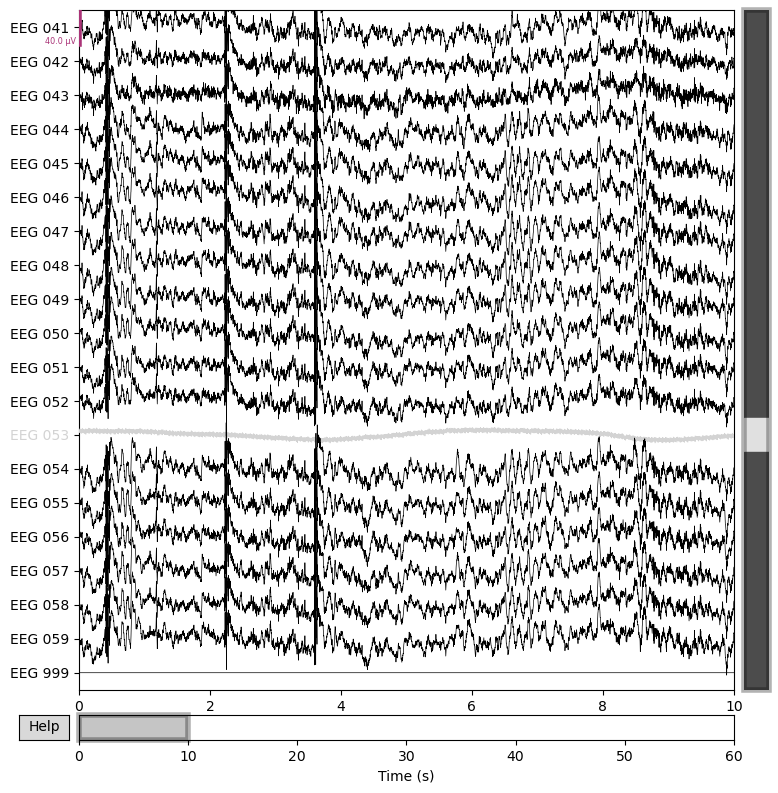

In [4]:
# add new reference channel (all zero)
raw_new_ref = mne.add_reference_channels(raw, ref_channels=['EEG 999'])
raw_new_ref.plot();

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


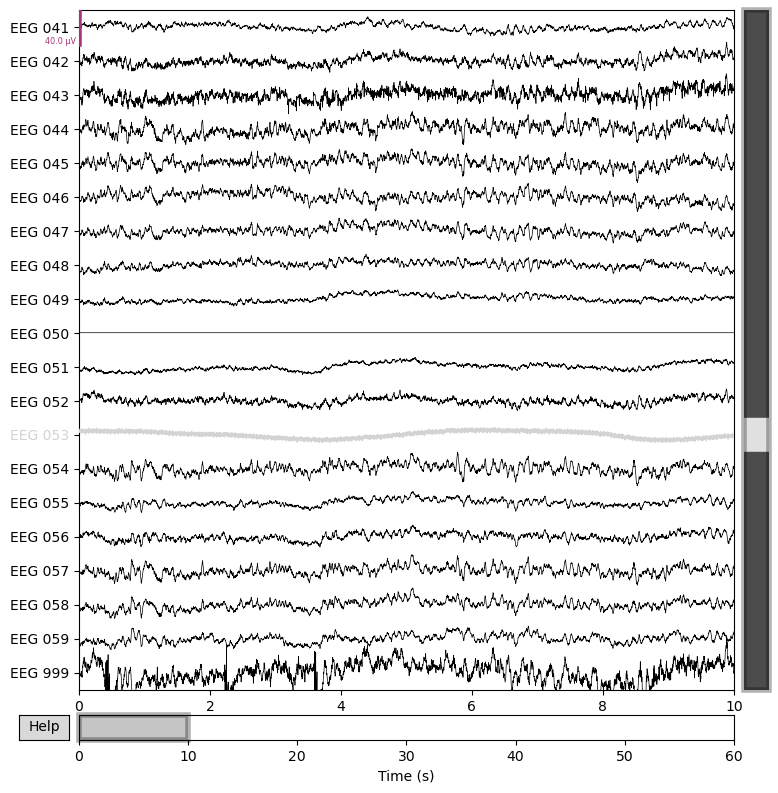

In [5]:
# set reference to `EEG 050`
raw_new_ref.set_eeg_reference(ref_channels=['EEG 050'])
raw_new_ref.plot();

setting average reference

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


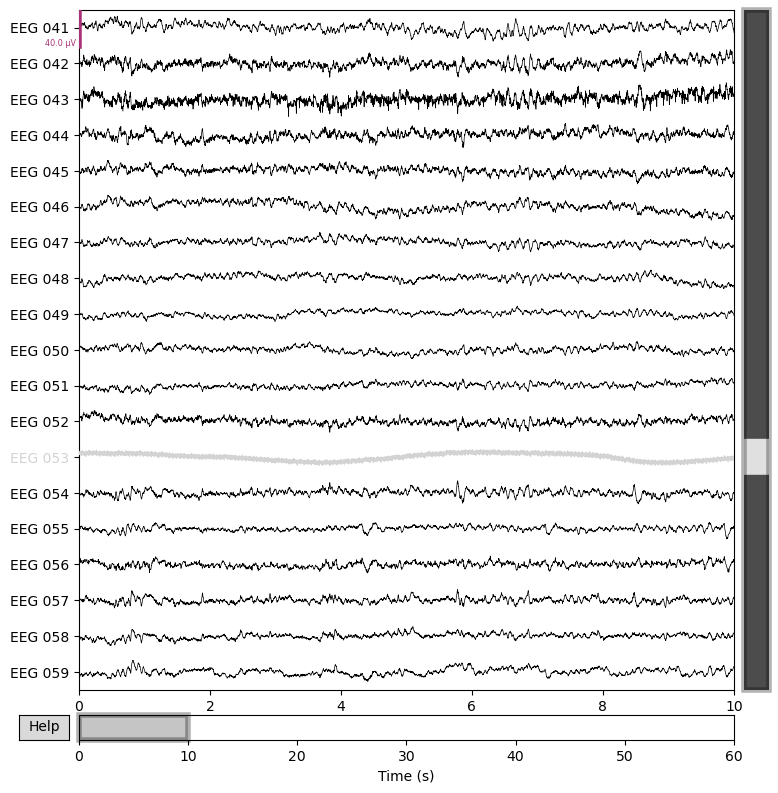

In [7]:
# use the average of all channels as reference
raw_avg_ref = raw.copy().set_eeg_reference(ref_channels='average')
raw_avg_ref.plot();

In [8]:
raw.set_eeg_reference('average', projection=True)
print(raw.info['projs'])

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
[<Projection | Average EEG reference, active : False, n_channels : 18>]


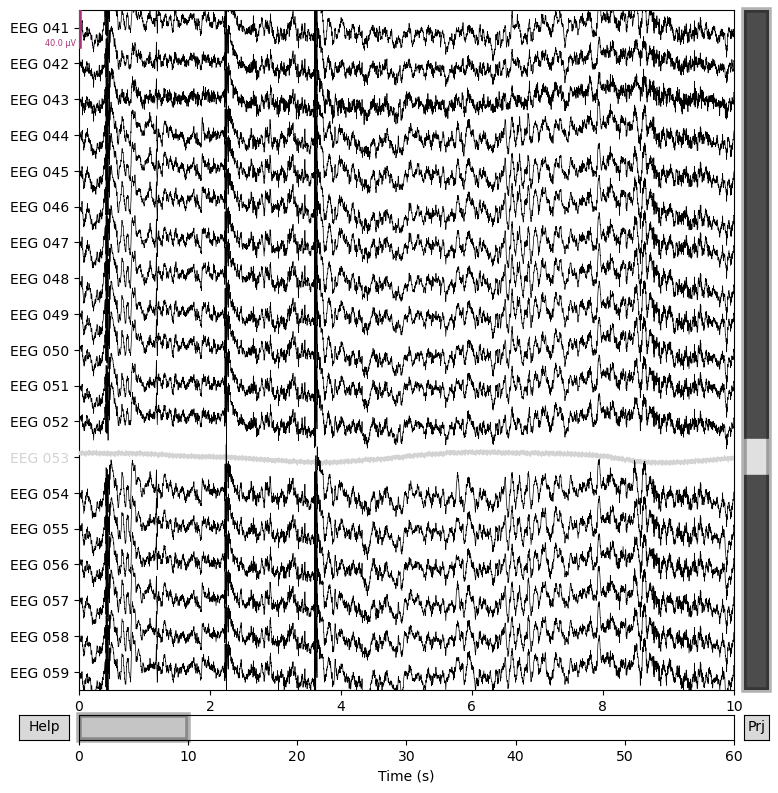

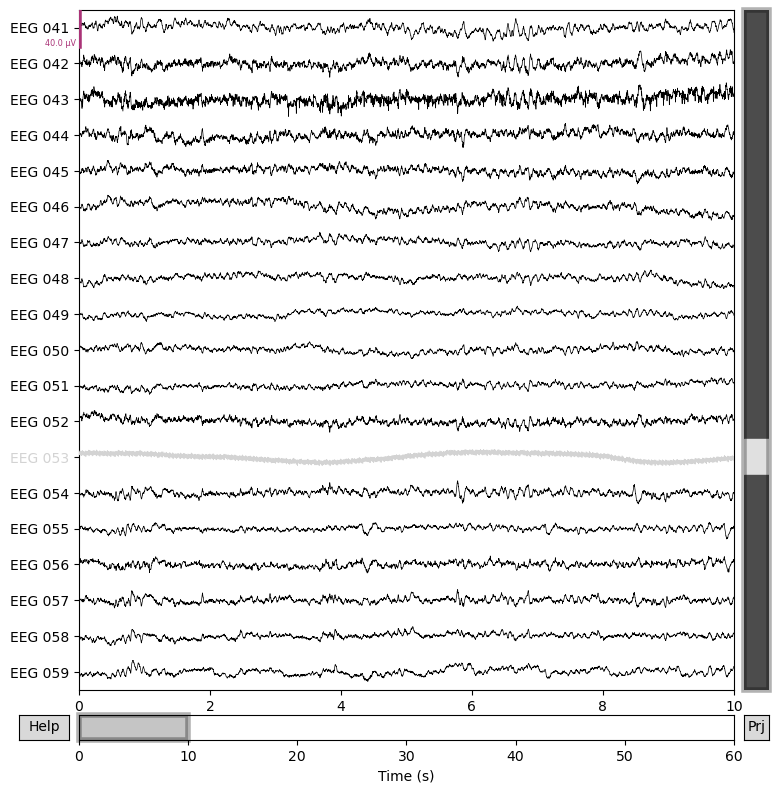

In [11]:
for title, proj in zip(['Original', 'Average'], [False, True]):
    with mne.viz.use_browser_backend('matplotlib'):
        fig = raw.plot(proj=proj, n_channels=len(raw))
    # make room for title
    fig.subplots_adjust(top=0.9)
    fig.suptitle('{} reference'.format(title), size='xx-large', weight='bold')

Fitted sphere radius:         91.0 mm
Origin head coordinates:      -4.1 16.0 51.7 mm
Origin device coordinates:    1.4 17.8 -10.3 mm

Equiv. model fitting -> RV = 0.00349057 %
mu1 = 0.944702    lambda1 = 0.137194
mu2 = 0.667435    lambda2 = 0.683781
mu3 = -0.26548    lambda3 = -0.0106058
Set up EEG sphere model with scalp radius    91.0 mm

Sphere                : origin at (-4.1 16.0 51.7) mm
              radius  : 81.9 mm
grid                  : 15.0 mm
mindist               : 5.0 mm
Exclude               : 30.0 mm

Setting up the sphere...
Surface CM = (  -4.1   16.0   51.7) mm
Surface fits inside a sphere with radius   81.9 mm
Surface extent:
    x =  -86.0 ...   77.8 mm
    y =  -65.9 ...   97.9 mm
    z =  -30.2 ...  133.7 mm
Grid extent:
    x =  -90.0 ...   90.0 mm
    y =  -75.0 ...  105.0 mm
    z =  -45.0 ...  135.0 mm
2197 sources before omitting any.
655 sources after omitting infeasible sources not within 30.0 - 81.9 mm.
532 sources remaining after excluding the sources

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Finished.
EEG channel type selected for re-referencing
Applying REST reference.
Applying a custom ('EEG',) reference.
    18 out of 19 channels remain after picking


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


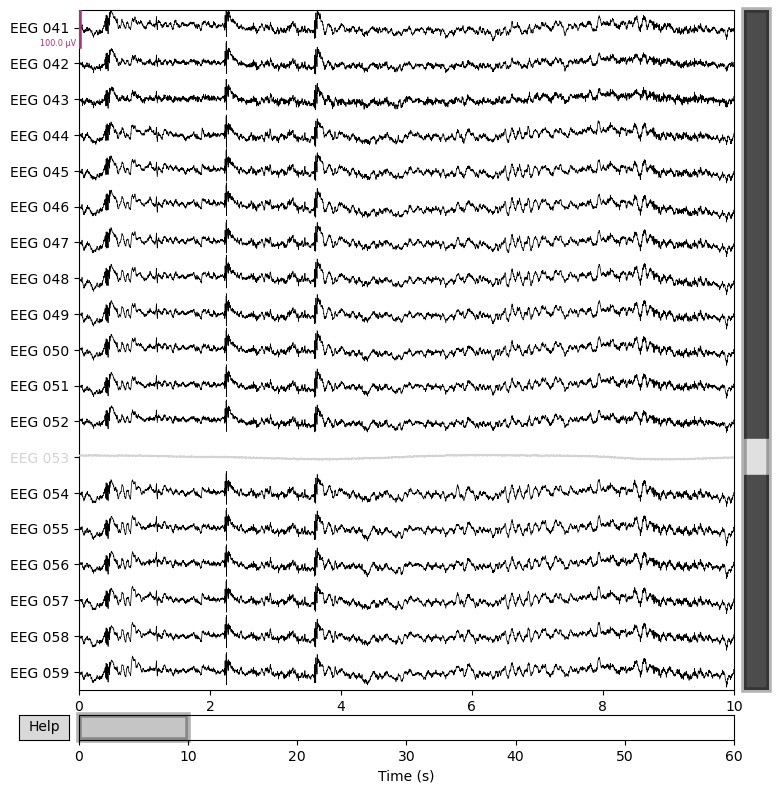

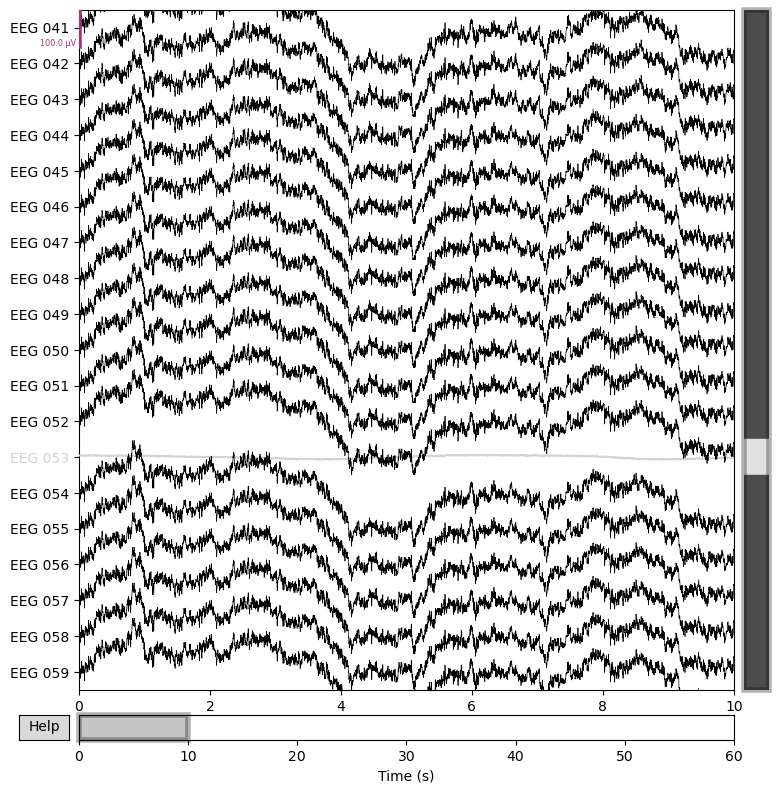

In [12]:
raw.del_proj()  # remove our average reference projector first
sphere = mne.make_sphere_model('auto', 'auto', raw.info)
src = mne.setup_volume_source_space(sphere=sphere, exclude=30., pos=15.)
forward = mne.make_forward_solution(raw.info, trans=None, src=src, bem=sphere)
raw_rest = raw.copy().set_eeg_reference('REST', forward=forward)

for title, _raw in zip(['Original', 'REST (∞)'], [raw, raw_rest]):
    with mne.viz.use_browser_backend('matplotlib'):
        fig = _raw.plot(n_channels=len(raw), scalings=dict(eeg=5e-5))
    # make room for title
    fig.subplots_adjust(top=0.9)
    fig.suptitle('{} reference'.format(title), size='xx-large', weight='bold')

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=36038
    Range : 25800 ... 61837 =     42.956 ...   102.956 secs
Ready.
Added the following bipolar channels:
EEG 054-EEG 055


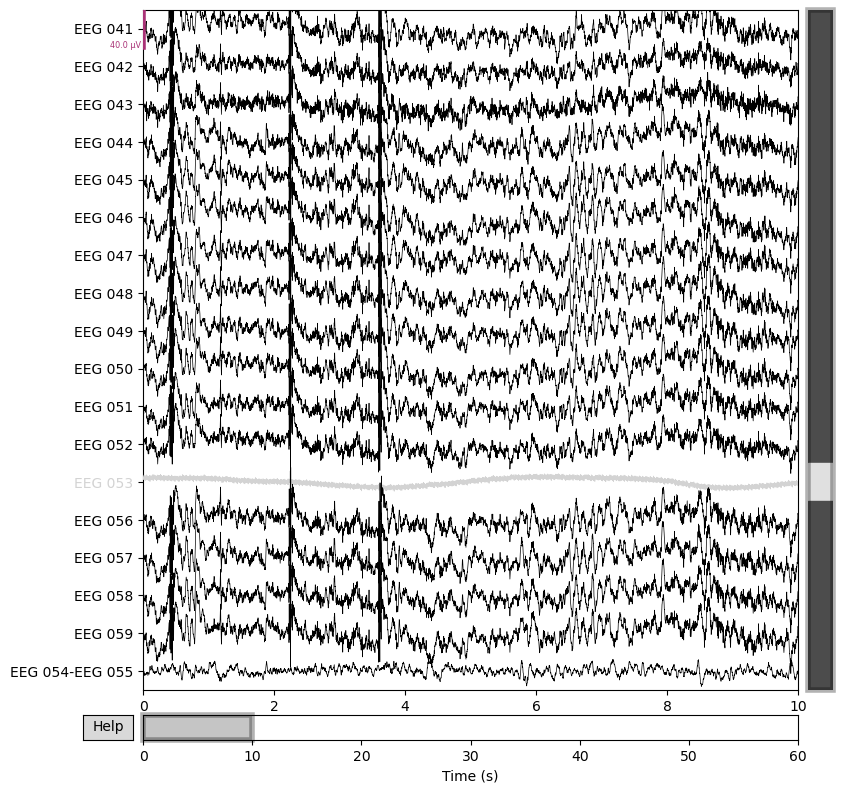

In [14]:
raw_bip_ref = mne.set_bipolar_reference(raw, anode=['EEG 054'],
                                        cathode=['EEG 055'])
raw_bip_ref.plot();

extracting and visualizing subject head movement

In [15]:
from os import path as op
import mne

data_path = op.join(mne.datasets.testing.data_path(verbose=True), 'SSS')
fname_raw = op.join(data_path, 'test_move_anon_raw.fif')
raw = mne.io.read_raw_fif(fname_raw, allow_maxshield='yes').load_data()
raw.plot_psd();

Opening raw data file /Users/DanDan/mne_data/MNE-testing-data/SSS/test_move_anon_raw.fif...
    Read a total of 12 projection items:
        mag.fif : PCA-v1 (1 x 306)  idle
        mag.fif : PCA-v2 (1 x 306)  idle
        mag.fif : PCA-v3 (1 x 306)  idle
        mag.fif : PCA-v4 (1 x 306)  idle
        mag.fif : PCA-v5 (1 x 306)  idle
        mag.fif : PCA-v6 (1 x 306)  idle
        mag.fif : PCA-v7 (1 x 306)  idle
        grad.fif : PCA-v1 (1 x 306)  idle
        grad.fif : PCA-v2 (1 x 306)  idle
        grad.fif : PCA-v3 (1 x 306)  idle
        grad.fif : PCA-v4 (1 x 306)  idle
        Average EEG reference (1 x 60)  idle
    Range : 10800 ... 31199 =      9.000 ...    25.999 secs
Ready.
Reading 0 ... 20399  =      0.000 ...    16.999 secs...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 0.213 (s)


/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


In [16]:
chpi_freqs, ch_idx, chpi_codes = mne.chpi.get_chpi_info(info=raw.info)
print(f'cHPI coil frequencies extracted from raw: {chpi_freqs} Hz')

Using 5 HPI coils: 83 143 203 263 323 Hz
cHPI coil frequencies extracted from raw: [ 83. 143. 203. 263. 323.] Hz


In [ ]:
# 1. extract the HPI coil amplitudes of times

In [17]:
chpi_amplitudes = mne.chpi.compute_chpi_amplitudes(raw)

Using 5 HPI coils: 83 143 203 263 323 Hz
Line interference frequencies: 60 120 180 240 300 360 Hz
Using time window: 83.3 ms
Fitting 5 HPI coil locations at up to 1696 time points (17.0 sec duration)


  0%|          | cHPI amplitudes : 0/1696 [00:00<?,       ?it/s]

In [ ]:
# 2. compute time-varying HPI coil locations 

In [18]:
chpi_locs = mne.chpi.compute_chpi_locs(raw.info, chpi_amplitudes)

Computing 4385 HPI location guesses (1 cm grid in a 10.7 cm sphere)
HPIFIT: 5 coils digitized in order 5 1 4 3 2
HPI consistency of isotrak and hpifit is OK.


  0%|          | cHPI locations  : 0/1696 [00:00<?,       ?it/s]

In [ ]:
# 3. compute head position from coil location

In [19]:
head_pos = mne.chpi.compute_head_pos(raw.info, chpi_locs, verbose=True)

    t=9.000:     5/5 good HPI fits, movements [mm/s] =      0.1 /      0.2 /      0.5 /      0.2 /      0.3
    t=10.000:    5/5 good HPI fits, movements [mm/s] =      0.1 /      0.2 /      0.0 /      0.1 /      0.1
    t=11.000:    5/5 good HPI fits, movements [mm/s] =      0.0 /      0.1 /      0.1 /      0.0 /      0.1
    t=12.000:    5/5 good HPI fits, movements [mm/s] =      0.0 /      0.0 /      0.0 /      0.0 /      0.0
    t=13.000:    5/5 good HPI fits, movements [mm/s] =      0.0 /      0.1 /      0.0 /      0.0 /      0.0
    t=14.000:    5/5 good HPI fits, movements [mm/s] =      0.1 /      0.1 /      0.1 /      0.1 /      0.1
    t=14.580:    5/5 good HPI fits, movements [mm/s] =      5.0 /      4.9 /      6.1 /      5.5 /      4.8
    t=14.670:    5/5 good HPI fits, movements [mm/s] =     33.4 /     33.3 /     39.8 /     37.9 /     30.4
    t=14.720:    5/5 good HPI fits, movements [mm/s] =     49.4 /     48.4 /     60.5 /     59.5 /     44.6
    t=14.760:    5/5 good HP

In [ ]:
# plot traces

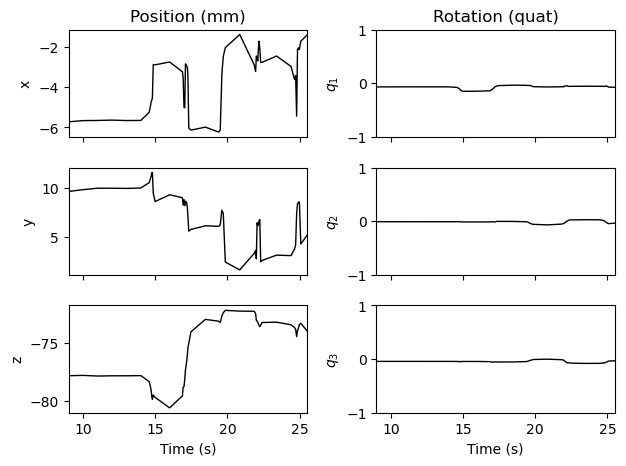

In [21]:
mne.viz.plot_head_positions(head_pos, mode='traces');

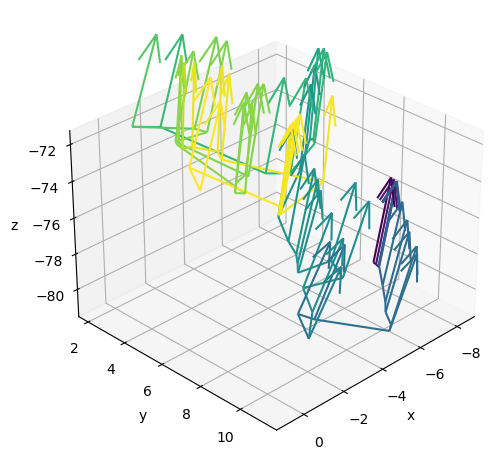

In [22]:
mne.viz.plot_head_positions(head_pos, mode='field');

In [28]:
raw.crop(tmin=1, tmax=2)
snr_dict = mne.chpi.compute_chpi_snr(raw)
fig = mne.viz.plot_chpi_snr(snr_dict);

Using 5 HPI coils: 83 143 203 263 323 Hz
Line interference frequencies: 60 120 180 240 300 360 Hz
Using time window: 83.3 ms
Fitting 5 HPI coil locations at up to 96 time points (1.0 sec duration)


  0%|          | cHPI SNRs : 0/96 [00:00<?,       ?it/s]

signal-space seperation SSS and maxwell filtering

In [30]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import mne
from mne.preprocessing import find_bad_channels_maxwell

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file, verbose=False)
raw.crop(tmax=60)

<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~3.3 MB, data not loaded>

Signal-space separation (SSS) [1][2] is a technique based on the physics of electromagnetic fields. SSS separates the measured signal into components attributable to sources inside the measurement volume of the sensor array (the internal components), and components attributable to sources outside the measurement volume (the external components). The internal and external components are linearly independent, so it is possible to simply discard the external components to reduce environmental noise. Maxwell filtering is a related procedure that omits the higher-order components of the internal subspace, which are dominated by sensor noise. Typically, Maxwell filtering and SSS are performed together (in MNE-Python they are implemented together in a single function).

Like SSP, SSS is a form of projection. Whereas SSP empirically determines a noise subspace based on data (empty-room recordings, EOG or ECG activity, etc) and projects the measurements onto a subspace orthogonal to the noise, SSS mathematically constructs the external and internal subspaces from spherical harmonics and reconstructs the sensor signals using only the internal subspace (i.e., does an oblique projection).

SSS & Maxwell filtering

In [31]:
fine_cal_file = os.path.join(sample_data_folder, 'SSS', 'sss_cal_mgh.dat')
crosstalk_file = os.path.join(sample_data_folder, 'SSS', 'ct_sparse_mgh.fif')

In [32]:
raw.info['bads'] = []
raw_check = raw.copy()
auto_noisy_chs, auto_flat_chs, auto_scores = find_bad_channels_maxwell(
    raw_check, cross_talk=crosstalk_file, calibration=fine_cal_file,
    return_scores=True, verbose=True)
print(auto_noisy_chs)  # we should find them!
print(auto_flat_chs)  # none for this dataset

Applying low-pass filter with 40.0 Hz cutoff frequency ...
Reading 0 ... 36037  =      0.000 ...    60.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 199 samples (0.331 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Scanning for bad channels in 12 intervals (5.0 sec) ...
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal_mgh.dat
        Adjusting non-orthogonal EX and EY


[Parallel(n_jobs=1)]: Done 366 out of 366 | elapsed:    1.2s finished


        Adjusted coil positions by (μ ± σ): 0.5° ± 0.4° (max: 2.1°)
    Automatic origin fit: head of radius 91.0 mm
    Using origin -4.1, 16.0, 51.7 mm in the head frame
        Interval   1:    0.000 -    4.998
        Interval   2:    5.000 -    9.998
        Interval   3:   10.000 -   14.998
        Interval   4:   15.000 -   19.998
        Interval   5:   20.000 -   24.998
        Interval   6:   24.999 -   29.998
        Interval   7:   29.999 -   34.997
        Interval   8:   34.999 -   39.997
        Interval   9:   39.999 -   44.997
        Interval  10:   44.999 -   49.997
        Interval  11:   49.999 -   54.997
        Interval  12:   54.999 -   60.000
    Static bad channels:  ['MEG 2443']
    Static flat channels: []
[done]
['MEG 2443']
[]


In [33]:
bads = raw.info['bads'] + auto_noisy_chs + auto_flat_chs
raw.info['bads'] = bads

In [40]:
# Only select the data for gradiometer channels.
ch_type = 'grad'
ch_subset = auto_scores['ch_types'] == ch_type
ch_names = auto_scores['ch_names'][ch_subset]
scores = auto_scores['scores_noisy'][ch_subset]
limits = auto_scores['limits_noisy'][ch_subset]
bins = auto_scores['bins']  # The the windows that were evaluated.
# We will label each segment by its start and stop time, with up to 3
# digits before and 3 digits after the decimal place (1 ms precision).
bin_labels = [f'{start:3.3f} – {stop:3.3f}'
              for start, stop in bins]

# We store the data in a Pandas DataFrame. The seaborn heatmap function
# we will call below will then be able to automatically assign the correct
# labels to all axes.
data_to_plot = pd.DataFrame(data=scores,
                            columns=pd.Index(bin_labels, name='Time (s)'),
                            index=pd.Index(ch_names, name='Channel'))

# First, plot the "raw" scores.
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
fig.suptitle(f'Automated noisy channel detection: {ch_type}',
             fontsize=16, fontweight='bold')
sns.heatmap(data=data_to_plot, cmap='Reds', cbar_kws=dict(label='Score'),
            ax=ax[0])
[ax[0].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
    for x in range(1, len(bins))]
ax[0].set_title('All Scores', fontweight='bold')

# Now, adjust the color range to highlight segments that exceeded the limit.
sns.heatmap(data=data_to_plot,
            vmin=np.nanmin(limits),  # bads in input data have NaN limits
            cmap='Reds', cbar_kws=dict(label='Score'), ax=ax[1])
[ax[1].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
    for x in range(1, len(bins))]
ax[1].set_title('Scores > Limit', fontweight='bold')

# The figure title should not overlap with the subplots.
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [38]:
raw.info['bads'] += ['MEG 2313']  # from manual inspection

raw_sss = mne.preprocessing.maxwell_filter(
    raw, cross_talk=crosstalk_file, calibration=fine_cal_file, verbose=True)

Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG 2443', 'MEG 2313']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal_mgh.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.5° ± 0.4° (max: 2.1°)
    Automatic origin fit: head of radius 91.0 mm
    Using origin -4.1, 16.0, 51.7 mm in the head frame
        Using 87/95 harmonic components for    0.000  (72/80 in, 15/15 out)
    Loading raw data from disk
    Processing 6 data chunks
[done]


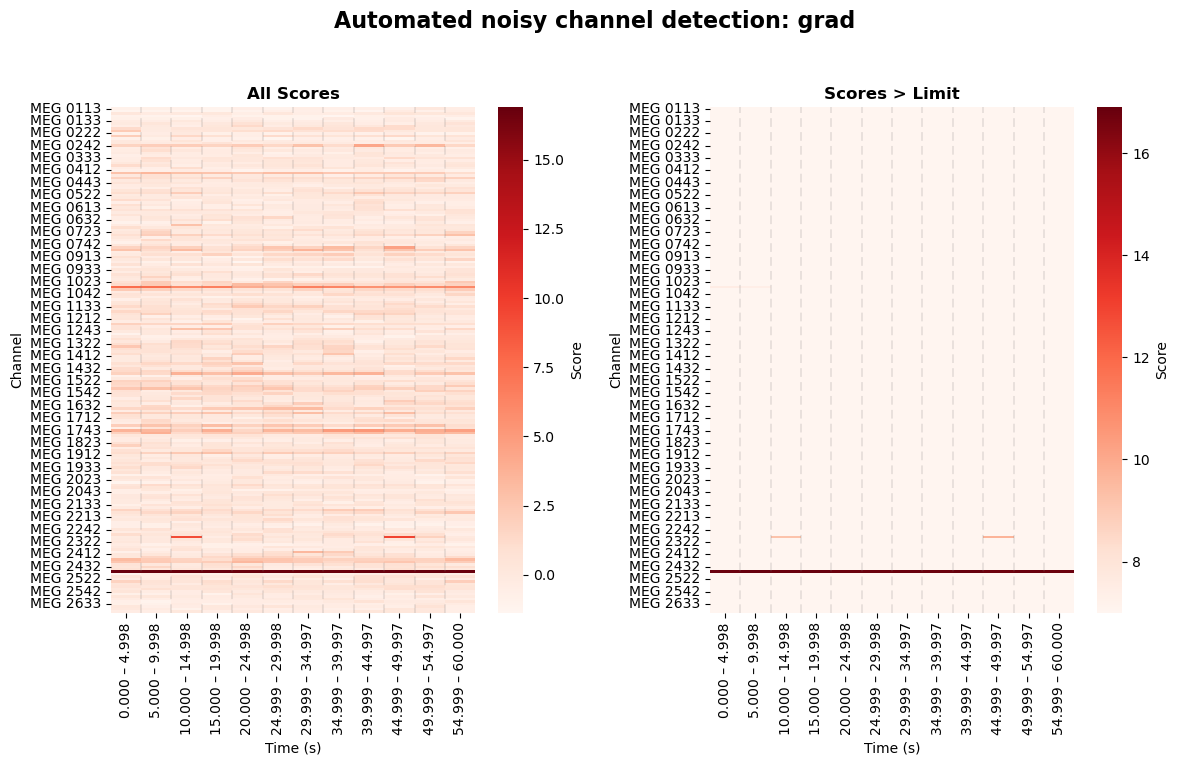

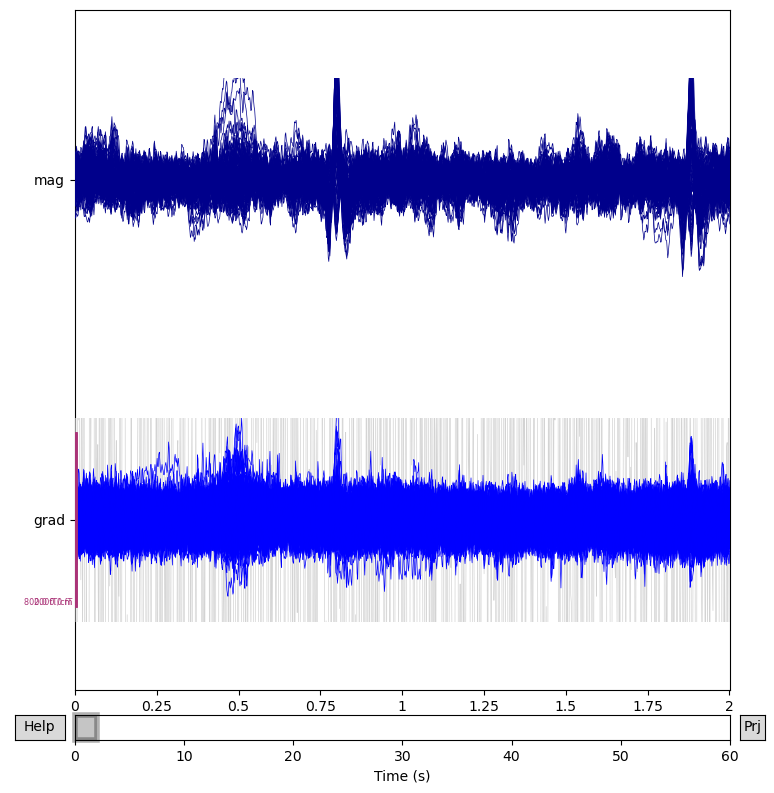

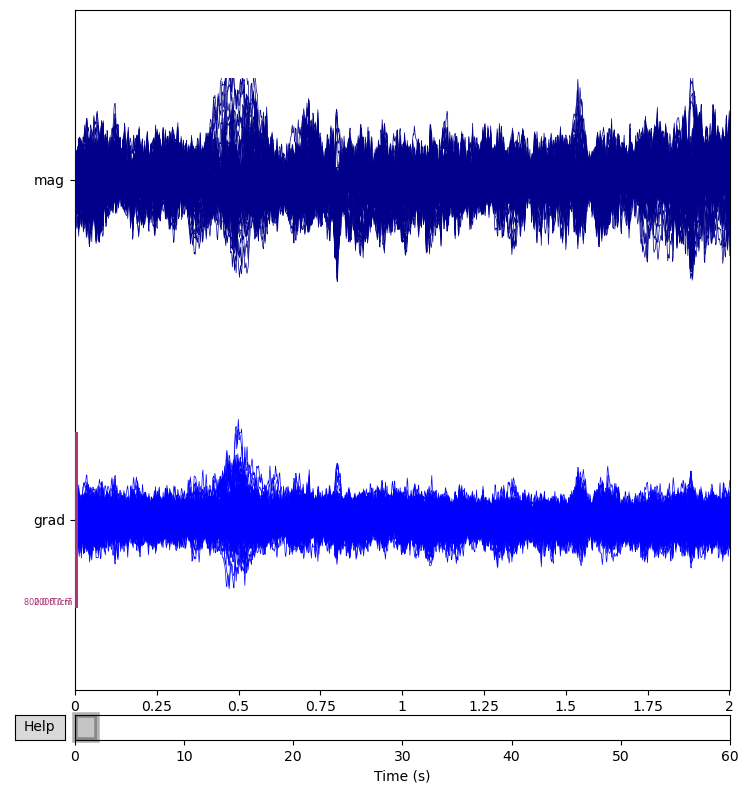

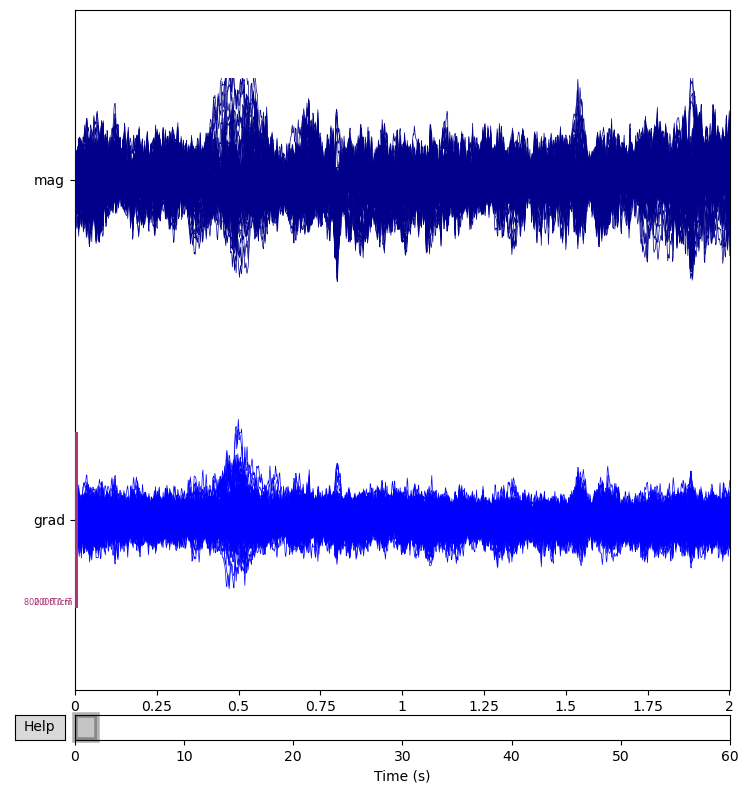

In [41]:
raw.pick(['meg']).plot(duration=2, butterfly=True)
raw_sss.pick(['meg']).plot(duration=2, butterfly=True)

that channels marked as “bad” have been effectively repaired by SSS, 

# tsss 

movingment compensation

In [43]:
chpi_fif_file = os.path.join(mne.datasets.testing.data_path(), 'SSS',
                             'test_move_anon_raw.fif')
raw = mne.io.read_raw_fif(chpi_fif_file, allow_maxshield='yes')

# time-resolved information on active HPI coils
# if all hpi were inactive n_active is a zero-array
n_active = mne.chpi.get_active_chpi(raw)
print(f'Average number of coils active during recording: {n_active.mean()}')

Opening raw data file /Users/DanDan/mne_data/MNE-testing-data/SSS/test_move_anon_raw.fif...
    Read a total of 12 projection items:
        mag.fif : PCA-v1 (1 x 306)  idle
        mag.fif : PCA-v2 (1 x 306)  idle
        mag.fif : PCA-v3 (1 x 306)  idle
        mag.fif : PCA-v4 (1 x 306)  idle
        mag.fif : PCA-v5 (1 x 306)  idle
        mag.fif : PCA-v6 (1 x 306)  idle
        mag.fif : PCA-v7 (1 x 306)  idle
        grad.fif : PCA-v1 (1 x 306)  idle
        grad.fif : PCA-v2 (1 x 306)  idle
        grad.fif : PCA-v3 (1 x 306)  idle
        grad.fif : PCA-v4 (1 x 306)  idle
        Average EEG reference (1 x 60)  idle
    Range : 10800 ... 31199 =      9.000 ...    25.999 secs
Ready.
Using 5 HPI coils: 83 143 203 263 323 Hz
Average number of coils active during recording: 5.0


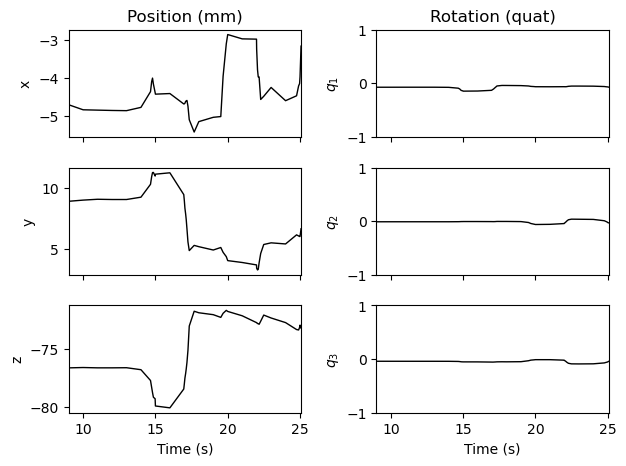

In [45]:
head_pos_file = os.path.join(mne.datasets.testing.data_path(), 'SSS',
                             'test_move_anon_raw.pos')
head_pos = mne.chpi.read_head_pos(head_pos_file)
mne.viz.plot_head_positions(head_pos, mode='traces');